# Facebook Results Loading - ATT

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import altair as alt
from IPython.display import HTML, display
from hive_query import hive_query
from hive_create import hive_create
from lxml import etree as ET
import boto, boto3
import hashlib
from concurrent.futures import ThreadPoolExecutor
import itertools
import bokeh

In [3]:
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [4]:
!pwd

/Users/jnatali/Drive/Action/Clients/ATT


In [5]:
config = 'platform_config.xml'
config

'platform_config.xml'

In [6]:
!cat $config

<?xml version="1.0" encoding="utf-8"?>
<configroot version="7.4">
  <set>
    <name>PLATFORM</name>
    <stringval>qubole</stringval>
  </set>
  <set>
    <name>CLIENT_TYPE</name>
    <stringval>abc</stringval>
  </set>
  <altiscale_settings>
    <set>
      <name>hive_cmd</name>
      <stringval>/opt/hive/bin/hive</stringval>
    </set>
    <set>
      <name>hadoop_cmd</name>
      <stringval>/opt/hadoop/bin/hadoop</stringval>
    </set>
    <set type="derived">
      <name>CLIENT_WAREHOUSE_LOC</name>
      <stringval/>
    </set>
    <set type="derived">
      <name>JARLOCATION</name>
      <stringval/>
    </set>
  </altiscale_settings>
  <qubole_settings>
    <set>
      <name>qds_cmd</name>
      <stringval>/usr/local/bin/qds.py</stringval>
    </set>
    <set>
      <name>s3cmd</name>
      <stringval>/usr/local/bin/s3cmd</stringval>
    </set>
    <set>
      <name>s3_location</name>
      <stringval>s3://qubole-att/warehouse/</stringval>
    </set>
    <set>
      <name>url</na

In [17]:
#elbis = '{lbis_db}.marketing_touches'
raw_db = 'att_v741_raw'
src_db = 'att_v741_src'
lbis_db = 'att_v741_lbis'
project_db = 'coeffstack_att_2019feb15_experimental_fb_mspatt_att_v741'
elbis_token = f'{project_db}.elbis_wvdates'
elbis = f'{lbis_db}.marketing_touches'
albis = f'{lbis_db}.conversions'
sessions = f'{lbis_db}.sessioninfo_orig_n_resolved_cols'
engagement = f'{project_db}.engagement_preproc'
lmt_fiscal = f'{lbis_db}.lmt_fiscal'
db = 'fb_integration_1'
fb_elbis = f'{db}.elbis_fb'
stack = f'{project_db}.coeffstack_modeldim'
stack_backbone = f'{db}.stack_bb'
fb_stack = f'{db}.stack_fb'
fb_stack_ext = f'{db}.stack_fb_ext'
fb_raw = f'{raw_db}.pierone_v74_ext_facebook_exposure_ext'
lookback = 30
group_size = 1000
brickhouse_jar = 's3://qubole-pier1/warehouse/jars/brickhouse-0.7.1-SNAPSHOT.jar'
tmp_s3_loc = 's3://qubole-pier1/tmp/fb_tmp_stack/'
engagementscore_scaling_factor = 3
engagementscore_stdev_factor = 1
cluster = 'Pier1-Modelling'

fb_raw = f'{raw_db}.ext_facebook_impressions'
fb_sync = f'{raw_db}.ext_facebook_orders'
id_mapping = f'{src_db}.fb_level_code_mapping'
old_stack = f'{project_db}.coeffstack_modeldim'

offline_id_map = f'{db}.audience_maid_full_20181119'

## Results raw files

`/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt`

From Andrew:

> DECRYPTION INSTRUCTIONS AND FILE CONTENTS  
> The file is a zip file that has then been encrypted using AES-256 in CBC mode. The following command is a simple way to decrypt it.  
>  
> `openssl aes-256-cbc -d -in ~/neustar_test_results.aes -out neustar_test_results.zip`  
>  
> Please use the decryption password I sent to Joao last week. The output of decryption is a regular zip file.  
> The files follow the naming scheme: `{name}_{cohort_strat}_{partner_id}_{source_id}_{date}.csv` where name is the type of report, cohort strat is the size of the cohort (these all use naive grouping), partner/source id is just neustar/pier1 ids. You can refer to the download script in the code example to see the exact contents. All files have headers, unlike production.

In [10]:
results_path = '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt'

In [11]:
!ls -la $results_path

total 142912
drwxr-xr-x  67 jnatali  CIS\Domain Users     2278 Feb 23 15:29 .
drwxr-xr-x  69 jnatali  CIS\Domain Users     2346 Feb 23 16:12 ..
-rw-r--r--   1 jnatali  CIS\Domain Users   171646 Feb 23 15:29 cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C740D4D.csv
-rw-r--r--   1 jnatali  CIS\Domain Users   181303 Feb 23 15:29 cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C7459A0.csv
-rw-r--r--   1 jnatali  CIS\Domain Users   178150 Feb 23 15:29 cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C746939.csv
-rw-r--r--   1 jnatali  CIS\Domain Users   185443 Feb 23 15:29 cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C7474FC.csv
-rw-r--r--   1 jnatali  CIS\Domain Users   201616 Feb 23 15:29 cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C747E05.csv
-rw-r--r--   1 jnatali  CIS\Domain U

In [25]:
!ls $results_path | wc -l

      65


In [13]:
%%bash
for filename in /Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/*.csv; do
    echo "=== $filename ==="
    head -n4 $filename
done

=== /Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C740D4D.csv ===
128900881029137,fb4671c3e3f4052dd5599172938f1de4c51a14f5,0,2019-W1
128900881029137,75e0fd77f503a6b4cff08f79f7ad298b1443677d,0,2019-W1
128900881029137,f6f6e9e720f298b935710a6842dcbe464870b977,0,2019-W1
128900881029137,00a3c3ab2435d9ade984b237e5198b8ac423ed06,0,2019-W1
=== /Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C7459A0.csv ===
128900881029137,2b42a74c55dee3be2c47163a700ce6f99a9ff0be,0,2019-W3
128900881029137,440307047594ecb9bb0d67c566f4696dce852af0,0,2019-W3
128900881029137,6084318e4d5d82f8f7673b6715830a5e9a4ed06c,0,2019-W3
128900881029137,9118e20b5184c28c722f5b79353de93d7a8cf152,0,2019-W3
=== /Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137membership_1000_1386462108046405_12890088

## Loading data into Hive

In [28]:
def create_hive_table(ftype, header, db, path, config):
    table_name = "fb_20190202_2_{}".format(ftype)
    search_path = os.path.join(path, "*{}*.csv".format(ftype))
    print(search_path)
    files = glob.glob(search_path)
    print(files)
    dfs = []
    for file_path in files:
        file = os.path.split(file_path)[-1]
        fname = os.path.splitext(file)[0]
        print(fname)
        df = pd.read_csv(file_path, header=None, names=header)
        if ftype not in ("taxonomy",):
            df["cohort_size"] = fname.split("_")[-4]
        dfs.append(df)
    full_df = pd.concat(dfs, ignore_index=True)
    full_df.info()
    hive_create(full_df, table_name, db, config)
    return table_name

In [29]:
results_path

'/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt'

In [30]:
schema =  {
    'membership': ('pixel_id', 'hh_id', 'cohort_number', 'week'),
    'metric': ('pixel_id', 'cohort_number', 'click_value', 'imp_value', 'week'),
    'summary': ('pixel_id', 'account_id', 'campaign_id', 'adset_id', 'ad_id', 'click_count', 'imps_count', 'week'),
    'taxonomy': ('pixel_id', 'account_id', 'account_name', 'campaign_id', 'campaign_name', 'adset_id', 'adset_name', 'ad_id', 'ad_name', 'click_or_imp', 'all_events', 'successful_events', 'week')
}

for ftype in schema:
    print("*** Working on: {}".format(ftype))
    header = schema[ftype]
    print(ftype, header)
    table_name = create_hive_table(ftype, header, db, results_path, config)
    print(table_name)
    query = f"SELECT * FROM {db}.{table_name} LIMIT 5;"
    print(query)
    display(hive_query(query, config=config))

*** Working on: membership
membership ('pixel_id', 'hh_id', 'cohort_number', 'week')
/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/*membership*.csv
['/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C774001.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C78082A.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C780ECD.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C78151B.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137membership_1000_1386462108046405_128900881029137_5C787243.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decryp

Job ID: 239216896
fb_20190202_2_membership
SELECT * FROM fb_integration_1.fb_20190202_2_membership LIMIT 5;
Job ID: 239218438


,pixel_id,hh_id,cohort_number,week,cohort_size
0,128900881029137,855abe2eb06b34ae8cacaddde64ebb57e2ec29b3,0,2019-W5,1000
1,128900881029137,f0cd1b7ccb7449e57425f1a88b9c82be430813c5,0,2019-W5,1000
2,128900881029137,b5b8735e4de46cc9aa29f36e942769e840d2d0e1,0,2019-W5,1000
3,128900881029137,bfb392da8621dd8ae7ef6dd9942a58cbf274f44f,0,2019-W5,1000
4,128900881029137,a075e4df9896f482ad3a109497efe96970e44648,0,2019-W5,1000


*** Working on: metric
metric ('pixel_id', 'cohort_number', 'click_value', 'imp_value', 'week')
/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/*metric*.csv
['/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137metrics_1000_1386462108046405_128900881029137_5C7732AF.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137metrics_1000_1386462108046405_128900881029137_5C773DB5.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137metrics_1000_1386462108046405_128900881029137_5C7823B9.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137metrics_1000_1386462108046405_128900881029137_5C786557.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137metrics_1000_1386462108046405_128900881029137_5C786C1B.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort

Job ID: 239218886
fb_20190202_2_metric
SELECT * FROM fb_integration_1.fb_20190202_2_metric LIMIT 5;
Job ID: 239219277


,pixel_id,cohort_number,click_value,imp_value,week,cohort_size
0,128900881029137,42,0.0,0.456309,2019-W3,1000
1,128900881029137,88,0.0,1.410893,2019-W3,1000
2,128900881029137,53,0.0,0.652826,2019-W3,1000
3,128900881029137,61,0.0,0.805632,2019-W3,1000
4,128900881029137,89,0.0,1.437151,2019-W3,1000


*** Working on: summary
summary ('pixel_id', 'account_id', 'campaign_id', 'adset_id', 'ad_id', 'click_count', 'imps_count', 'week')
/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/*summary*.csv
['/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137summary_1000_1386462108046405_128900881029137_5C772B27.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137summary_1000_1386462108046405_128900881029137_5C78272C.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137summary_1000_1386462108046405_128900881029137_5C783556.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137summary_1000_1386462108046405_128900881029137_5C78554D.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137summary_1000_1386462108046405_128900881029137_5C7860D6.csv', '/Users/jnatali/repos/fb

Job ID: 239222602
fb_20190202_2_summary
SELECT * FROM fb_integration_1.fb_20190202_2_summary LIMIT 5;
Job ID: 239223755


,pixel_id,account_id,campaign_id,adset_id,ad_id,click_count,imps_count,week,cohort_size
0,128900881029137,1932509527010424,23843227922910492,23843227922920492,23843235767640492,0,42,2019-W3,1000
1,128900881029137,1932509527010424,23843228173040492,23843228173030492,23843228240740492,0,160,2019-W3,1000
2,128900881029137,1055019464536356,6113378961817,6114766112217,6118930956617,0,32,2019-W3,1000
3,128900881029137,1929120184016025,23843461009430436,23843464936400436,23843468489180436,0,414,2019-W3,1000
4,128900881029137,1823714347754987,23843252220660768,23843252300000768,23843255097150768,0,3,2019-W3,1000


*** Working on: taxonomy
taxonomy ('pixel_id', 'account_id', 'account_name', 'campaign_id', 'campaign_name', 'adset_id', 'adset_name', 'ad_id', 'ad_name', 'click_or_imp', 'all_events', 'successful_events', 'week')
/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/*taxonomy*.csv
['/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137taxonomy_1386462108046405_128900881029137_5C7802B7.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137taxonomy_1386462108046405_128900881029137_5C780A55.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137taxonomy_1386462108046405_128900881029137_5C7811A4.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137taxonomy_1386462108046405_128900881029137_5C7820E8.csv', '/Users/jnatali/repos/fb_mta/notebooks/reports/decrypt/cohort_1386462108046405_128900881029137taxonomy_138646210

,pixel_id,account_id,account_name,campaign_id,campaign_name,adset_id,adset_name,ad_id,ad_name,click_or_imp,all_events,successful_events,week
0,128900881029137,1055019464536356,Cricket (AT&T) Seq Uni Bill,6116952709417,99970 * ATT-Cricket Local West * COS Dilley * ...,6116952709817,Drive to Retail Neustar 2,6117066499817,L_ACW_CRI_006_Facebook_1_OLV_CRS_NA_ROS_1x1_NI...,IM,0,4,2019-W5
1,128900881029137,261631468018234,AT&T Mobility ALT - Prepaid,23843062037960343,L_AMB_P65_06_AWA_ATT-055436 Prepaid Q4 GM_Q4_2...,23843062070790343,L_AMB_P65_06_Facebook/Instagram_01_PPL_CRS_NA_...,23843067317490343,L_AMB_P65_06_Facebook/Instagram_01_CPO_CRS_NA_...,IM,0,6,2019-W5
2,128900881029137,557786071082784,ATT,23843154865710726,L_AEC_ECM_006_ECM_POST_SS_010119A-331_CNV_1H_2...,23843154868800726,L_AEC_ECM_006_SS_CRS_POST_CS_na-0015-Mobile-f,23843154867230726,L_AEC_ECM_006_SS_PPL_MIX_CRS_NA_VID_na-0015HS-...,CL,0,4,2019-W5
3,128900881029137,557786071082784,ATT,23843154865670726,L_AEC_ECM_006_ECM_POST_SS_010119A-330_CNV_1H_2...,23843154868380726,L_AEC_ECM_006_SS_RTG_POST_LF_s9-0015-Mobile-i,23843154866140726,L_AEC_ECM_006_SS_PPL_MIX_RTG_NA_VID_s9-0015HM-...,IM,0,40,2019-W5
4,128900881029137,1023987617639541,AT&T Seq Uni BIll,6100840570865,98837 * ATT - ABS - Strategic Services - Micro...,6100840577465,(OPE Healthcare Bombora)[Link Clicks]{SS MidFu...,6100955799665,10/01 - 12/31 [10156411567472334] (L_ABU_STS_0...,IM,0,30,2019-W5


In [23]:
hive_query("SELECT cohort_size, COUNT(*) FROM fb_integration_1.fb_20190202_2_metric GROUP BY cohort_size", config=config)

Job ID: 238472201


,cohort_size,c1
0,1,13515
1,10,1353
2,100,138
3,1000,15


In [24]:
hive_query("SELECT * FROM fb_integration_1.fb_20190202_2_membership where cohort_size = 1 LIMIT 10", config=config)

Job ID: 238473443


,pixel_id,hh_id,cohort_number,week,cohort_size
0,128900881029137,11c957eb19840b0b505733de6ed89ddd3776eddb,1023,2019-W5,1
1,128900881029137,382d3d0ea268b4ed632f929c7ce6a419f4da30ab,1024,2019-W5,1
2,128900881029137,e0beef103c96fcbdd322a1c5347b509b071f5ead,1025,2019-W5,1
3,128900881029137,94f6067cba9f2f7fd956dd0ac2bc846729ad1fa1,1026,2019-W5,1
4,128900881029137,867652d4af16a497e4f45949e17f67de26cc47b1,1027,2019-W5,1
5,128900881029137,fc085e61aaecf2b179859a3b155e061005a83b09,1028,2019-W5,1
6,128900881029137,466d16a9b979b83b893b6d23fce69665fb2b0a64,1029,2019-W5,1
7,128900881029137,86630512d690da5e4fe89cfb1a3f8ef47cc4ad6c,1030,2019-W5,1
8,128900881029137,c9298969ce99e1a7adfcdd0de14d596d5a46d6e5,1031,2019-W5,1
9,128900881029137,19404f390844a4870f1b6faa7f20159767948e5e,1032,2019-W5,1


In [31]:
hive_query("SELECT * FROM fb_integration_1.fb_20190202_2_taxonomy LIMIT 5", config=config)

Job ID: 240441684


,pixel_id,account_id,account_name,campaign_id,campaign_name,adset_id,adset_name,ad_id,ad_name,click_or_imp,all_events,successful_events,week
0,128900881029137,1055019464536356,Cricket (AT&T) Seq Uni Bill,6116952709417,99970 * ATT-Cricket Local West * COS Dilley * ...,6116952709817,Drive to Retail Neustar 2,6117066499817,L_ACW_CRI_006_Facebook_1_OLV_CRS_NA_ROS_1x1_NI...,IM,0,4,2019-W5
1,128900881029137,261631468018234,AT&T Mobility ALT - Prepaid,23843062037960343,L_AMB_P65_06_AWA_ATT-055436 Prepaid Q4 GM_Q4_2...,23843062070790343,L_AMB_P65_06_Facebook/Instagram_01_PPL_CRS_NA_...,23843067317490343,L_AMB_P65_06_Facebook/Instagram_01_CPO_CRS_NA_...,IM,0,6,2019-W5
2,128900881029137,557786071082784,ATT,23843154865710726,L_AEC_ECM_006_ECM_POST_SS_010119A-331_CNV_1H_2...,23843154868800726,L_AEC_ECM_006_SS_CRS_POST_CS_na-0015-Mobile-f,23843154867230726,L_AEC_ECM_006_SS_PPL_MIX_CRS_NA_VID_na-0015HS-...,CL,0,4,2019-W5
3,128900881029137,557786071082784,ATT,23843154865670726,L_AEC_ECM_006_ECM_POST_SS_010119A-330_CNV_1H_2...,23843154868380726,L_AEC_ECM_006_SS_RTG_POST_LF_s9-0015-Mobile-i,23843154866140726,L_AEC_ECM_006_SS_PPL_MIX_RTG_NA_VID_s9-0015HM-...,IM,0,40,2019-W5
4,128900881029137,1023987617639541,AT&T Seq Uni BIll,6100840570865,98837 * ATT - ABS - Strategic Services - Micro...,6100840577465,(OPE Healthcare Bombora)[Link Clicks]{SS MidFu...,6100955799665,10/01 - 12/31 [10156411567472334] (L_ABU_STS_0...,IM,0,30,2019-W5


In [34]:
query = f"""
SELECT
    week
  , SUM(all_events) AS all_events
  , SUM(successful_events) AS successful_events
FROM
fb_integration_1.fb_20190202_2_taxonomy
GROUP BY
    week
"""
hive_query(query, config=config)

Job ID: 240442591


,week,all_events,successful_events
0,2019-W1,94513064.0,3048044.0
1,2019-W2,80099406.0,3113075.0
2,2019-W3,76486279.0,2701369.0
3,2019-W4,97452372.0,2396789.0
4,2019-W5,126613008.0,2429463.0


In [25]:
query = f"""
SELECT
    cohort_size
  , week
  , COUNT(*) AS num_rows
  , COUNT(DISTINCT hh_id) AS num_hh
FROM
    {db}.fb_20190202_2_membership
GROUP BY
    cohort_size
  , week
"""
hive_query(query, config=config)

Job ID: 238188051


,cohort_size,week,num_rows,num_hh
0,1,2019-W1,2527,2527
1,10,2019-W1,2527,2527
2,100,2019-W1,2527,2527
3,1000,2019-W1,2527,2527
4,1,2019-W2,2729,2729
5,10,2019-W2,2729,2729
6,100,2019-W2,2729,2729
7,1000,2019-W2,2729,2729
8,1,2019-W3,2669,2669
9,10,2019-W3,2669,2669


In [26]:
query = f"""
SELECT
    cohort_size
  , week
  , cohort_number
  , COUNT(*) AS num_rows
  , COUNT(DISTINCT hh_id) AS num_ids
FROM
    {db}.fb_20190202_2_membership
WHERE
    cohort_size > 1
GROUP BY
    cohort_size
  , week
  , cohort_number
HAVING
    num_ids NOT IN (1, 10, 100, 1000)
ORDER BY
    num_ids
"""
hive_query(query, config=config, nrows=None)

Job ID: 238188232


,cohort_size,week,cohort_number,num_rows,num_ids
0,10,2019-W4,262,2,2
1,10,2019-W1,252,7,7
2,10,2019-W5,296,8,8
3,10,2019-W2,272,9,9
4,10,2019-W3,266,9,9
5,100,2019-W4,26,22,22
6,100,2019-W1,25,27,27
7,100,2019-W2,27,29,29
8,100,2019-W5,29,68,68
9,100,2019-W3,26,69,69


In [41]:
query = f"""
SELECT
    week
  , COUNT(*)
FROM {db}.fb_20190202_2_membership
GROUP BY week
"""
hive_query(query, config=config)

Job ID: 238207522


,week,c1
0,2019-W1,10108
1,2019-W2,10916
2,2019-W3,10676
3,2019-W4,10488
4,2019-W5,11872


**Notes**:
* Cohorting still done in such a way that the last cohort may have significantly less IDs than most

## Data validation

### NULLs

In [27]:
query = f"""
SELECT
    week
  , cohort_size
  , COUNT(*) AS num_rows
  , SUM(CASE WHEN imp_value IS NULL THEN 1 ELSE 0 END) AS num_null_imp
  , SUM(CASE WHEN click_value IS NULL THEN 1 ELSE 0 END) AS num_null_click
FROM
    {db}.fb_20190202_2_metric
GROUP BY
    week
  , cohort_size
ORDER BY
    week
  , cohort_size
"""
nulls_metrics = hive_query(query, config=config)
nulls_metrics

Job ID: 238188439


,week,cohort_size,num_rows,num_null_imp,num_null_click
0,2019-W1,1,2527,0,0
1,2019-W1,10,253,0,0
2,2019-W1,100,26,0,0
3,2019-W1,1000,3,0,0
4,2019-W2,1,2729,0,0
5,2019-W2,10,273,0,0
6,2019-W2,100,28,0,0
7,2019-W2,1000,3,0,0
8,2019-W3,1,2669,0,0
9,2019-W3,10,267,0,0


In [28]:
# hh_id	cohort_number
query = f"""
SELECT
    week
  , cohort_size
  , COUNT(*) AS num_rows
  , SUM(CASE WHEN hh_id IS NULL THEN 1 ELSE 0 END) AS num_null_hh_id
  , SUM(CASE WHEN cohort_number IS NULL THEN 1 ELSE 0 END) AS num_null_cohort_number
FROM
    {db}.fb_20190202_2_membership
GROUP BY
    week
  , cohort_size
ORDER BY
    week
  , cohort_size
"""
nulls_memb = hive_query(query, config=config)
nulls_memb

Job ID: 238188637


,week,cohort_size,num_rows,num_null_hh_id,num_null_cohort_number
0,2019-W1,1,2527,0,0
1,2019-W1,10,2527,0,0
2,2019-W1,100,2527,0,0
3,2019-W1,1000,2527,0,0
4,2019-W2,1,2729,0,0
5,2019-W2,10,2729,0,0
6,2019-W2,100,2729,0,0
7,2019-W2,1000,2729,0,0
8,2019-W3,1,2669,0,0
9,2019-W3,10,2669,0,0


### Feature values

In [29]:
query = f"""
SELECT
    week
  , cohort_size
  , COUNT(*) AS num_rows
  , SUM(imp_value) AS tot_imp_value
  , SUM(click_value) AS tot_click_value
FROM
    {db}.fb_20190202_2_metric
GROUP BY
    week
  , cohort_size
ORDER BY
    week
  , cohort_size
"""
val_metrics = hive_query(query, config=config)
val_metrics

Job ID: 238188787


,week,cohort_size,num_rows,tot_imp_value,tot_click_value
0,2019-W1,1,2527,7308.978748,316.824180
1,2019-W1,10,253,733.155523,33.111180
2,2019-W1,100,26,77.808818,5.773192
3,2019-W1,1000,3,9.573655,0.601184
4,2019-W2,1,2729,7618.993434,333.181556
5,2019-W2,10,273,762.566600,33.724308
6,2019-W2,100,28,80.764907,5.629514
7,2019-W2,1000,3,8.884756,0.457039
8,2019-W3,1,2669,7352.122453,290.956646
9,2019-W3,10,267,735.884278,29.489766


### Cohort ordering

In [30]:
# cohort_number	click_value	imp_value	cohort_size	week
query = f"""
SELECT
    *
FROM
    {db}.fb_20190202_2_metric
"""
metric = hive_query(query, config=config, nrows=None, dtype={'cohort_number': np.int32, 'cohort_size': np.int16}, na_values=[r'\N'])
metric.info()

Job ID: 238189047
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15021 entries, 0 to 15020
Data columns (total 6 columns):
pixel_id         15021 non-null int64
cohort_number    15021 non-null int32
click_value      15021 non-null float64
imp_value        15021 non-null float64
week             15021 non-null object
cohort_size      15021 non-null int16
dtypes: float64(2), int16(1), int32(1), int64(1), object(1)
memory usage: 557.5+ KB


In [31]:
metric.assign(normalized_cohort_number = lambda x: x.cohort_number * x.cohort_size).sample(20)

,pixel_id,cohort_number,click_value,imp_value,week,cohort_size,normalized_cohort_number
5254,128900881029137,1526,0.000000,3.219800,2019-W4,1,1526
14518,128900881029137,1976,0.000000,4.441961,2019-W3,1,1976
3868,128900881029137,461,0.000000,1.166206,2019-W1,1,461
8507,128900881029137,1908,0.000000,4.167259,2019-W2,1,1908
328,128900881029137,91,0.000000,1.841886,2019-W5,10,910
4725,128900881029137,1448,0.000000,3.049879,2019-W4,1,1448
6271,128900881029137,1830,0.000000,3.974904,2019-W4,1,1830
6706,128900881029137,1684,0.000000,3.545375,2019-W2,1,1684
1520,128900881029137,144,0.000000,0.201720,2019-W1,1,144
56,128900881029137,25,0.593267,4.200918,2019-W2,100,2500


/Users/jnatali/miniconda3/envs/main/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


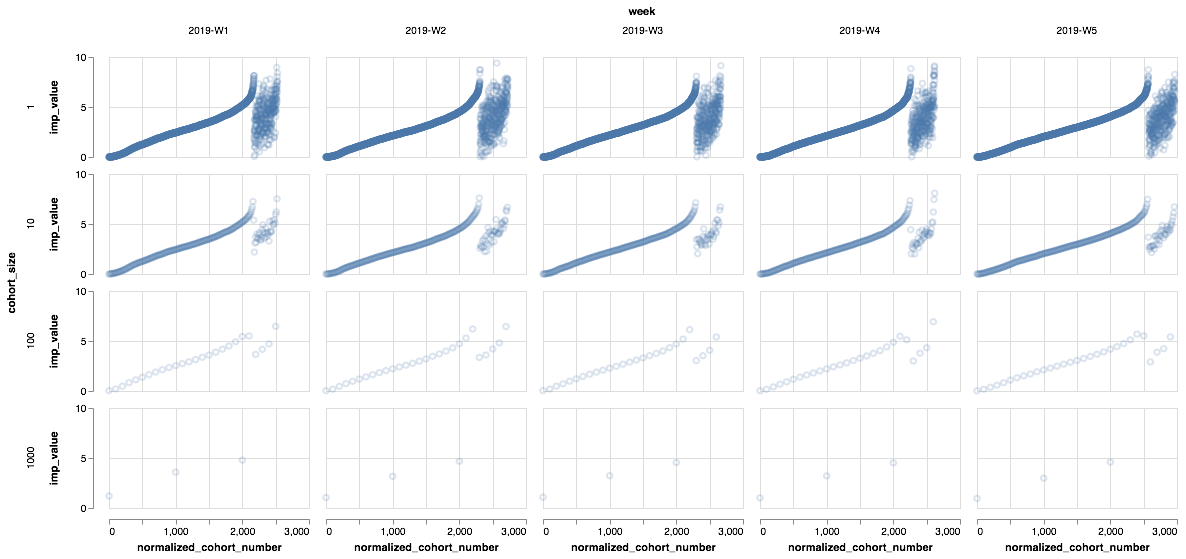

In [32]:
alt.Chart(
    data = metric.assign(normalized_cohort_number = lambda x: x.cohort_number * x.cohort_size),
    width = 200,
    height = 100
).mark_point(
    opacity = 0.2
).encode(
    x='normalized_cohort_number',
    y='imp_value',
    row='cohort_size:O',
    column='week'
)

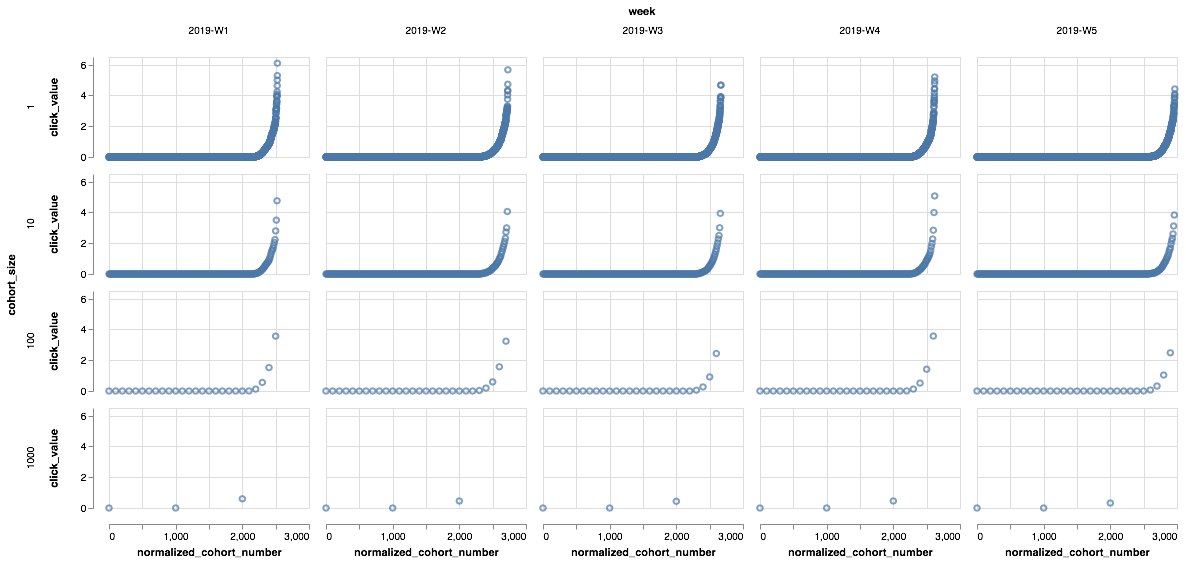

In [33]:
alt.Chart(
    data = metric.assign(normalized_cohort_number = lambda x: x.cohort_number * x.cohort_size),
    width = 200,
    height = 100
).mark_point(
).encode(
    x='normalized_cohort_number',
    y='click_value',
    row='cohort_size:O',
    column='week'
)

### Feature correlations

Steps:
1. Merge cohort membership with merics to get metrics at the hh_id level
1. Compute correlations at the ID level

In [34]:
query = f"""
DROP TABLE IF EXISTS {db}.fb_20190202_2_metric_hh;
CREATE TABLE {db}.fb_20190202_2_metric_hh STORED AS ORC AS
SELECT
    t1.*
  , t2.hh_id
FROM
    {db}.fb_20190202_2_metric t1
JOIN
    {db}.fb_20190202_2_membership t2
ON
    t1.week = t2.week AND
    t1.cohort_size = t2.cohort_size AND
    t1.cohort_number = t2.cohort_number
;"""
hive_query(query, config=config)

Job ID: 238189266


,pixel_id,cohort_number,click_value,imp_value,week,cohort_size,hh_id


In [35]:
query = f"""
SELECT
    cohort_size
  , cohort_number
  , week
  , COUNT(*) AS num_rows
  , COUNT(DISTINCT hh_id) AS num_ids
FROM
    {db}.fb_20190202_2_metric_hh
GROUP BY
    cohort_size
  , cohort_number
  , week
LIMIT 20
"""
hive_query(query, config=config, nrows=None)

Job ID: 238189463


,cohort_size,cohort_number,week,num_rows,num_ids
0,1,0,2019-W1,1,1
1,10,0,2019-W1,10,10
2,100,0,2019-W1,100,100
3,1000,0,2019-W1,1000,1000
4,1,0,2019-W2,1,1
5,10,0,2019-W2,10,10
6,100,0,2019-W2,100,100
7,1000,0,2019-W2,1000,1000
8,1,0,2019-W3,1,1
9,10,0,2019-W3,10,10


In [36]:
query = f"""
SELECT
    t1.week
  , t2.cohort_size
  , corr(t1.imp_value, t2.imp_value) as imp_corr
  , corr(t1.click_value, t2.click_value) as click_corr
  , COUNT(*) AS num_rows
  , COUNT(DISTINCT t1.hh_id) AS num_ids
FROM (
    SELECT
        *
    FROM
        {db}.fb_20190202_2_metric_hh
    WHERE
        cohort_size = 1
    ) t1
JOIN (
    SELECT
        *
    FROM
        {db}.fb_20190202_2_metric_hh
    ) t2
ON
    t1.week = t2.week AND
    t1.hh_id = t2.hh_id
GROUP BY
    t1.week
  , t2.cohort_size
;"""
metric_corr = hive_query(query, nrows=None, config=config)
metric_corr

Job ID: 238189637


,week,cohort_size,imp_corr,click_corr,num_rows,num_ids
0,2019-W1,1,1.000000,1.000000,2527,2527
1,2019-W1,10,0.956756,0.995861,2527,2527
2,2019-W1,100,0.934417,0.964917,2527,2527
3,2019-W1,1000,0.824648,0.496866,2527,2527
4,2019-W2,1,1.000000,1.000000,2729,2729
5,2019-W2,10,0.956288,0.995146,2729,2729
6,2019-W2,100,0.934711,0.967931,2729,2729
7,2019-W2,1000,0.829392,0.435903,2729,2729
8,2019-W3,1,1.000000,1.000000,2669,2669
9,2019-W3,10,0.956436,0.997695,2669,2669


In [39]:
metric_hh = hive_query(f"SELECT * FROM {db}.fb_20190202_2_metric_hh;", nrows=None, config=config)
metric_hh.info()

Job ID: 238191528
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54060 entries, 0 to 54059
Data columns (total 7 columns):
pixel_id         54060 non-null int64
cohort_number    54060 non-null int64
click_value      54060 non-null float64
imp_value        54060 non-null float64
week             54060 non-null object
cohort_size      54060 non-null int64
hh_id            54060 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 2.9+ MB


In [38]:
ch1 = metric_hh[(metric_hh.week=='2018-09-17') & (metric_hh.cohort_size==1)].set_index('hh_id').imp_value
ch10 = metric_hh[(metric_hh.week=='2018-09-17') & (metric_hh.cohort_size==10)].set_index('hh_id').imp_value
pd.concat((ch1, ch10), axis=1, sort=True).corr()

,imp_value,imp_value
imp_value,NaN,NaN
imp_value,NaN,NaN


## Cohort tests

In [21]:
query = f"""
SELECT
    cohort_size
  , week
  , MAX(cohort_number) AS max_cohort
  , MIN(cohort_number) AS min_cohort
  , COUNT(DISTINCT cohort_number) AS dist_cohort
  , COUNT(*) AS num_rows
  , COUNT(DISTINCT hh_id) AS num_ids
  , floor(COUNT(*)/cohort_size) AS num_cohorts
FROM
    {db}.fb_20190202_2_membership
GROUP BY
    cohort_size
  , week
"""
cohort_summary = hive_query(query, config=config)
cohort_summary

Job ID: 212955979


,cohort_size,week,max_cohort,min_cohort,dist_cohort,num_rows,num_ids,num_cohorts
0,1,2018-W31,50662,0,50663,50663,50663,50663
1,1,2018-W32,57752,0,57753,57753,57753,57753
2,1,2018-W33,62309,0,62310,62310,62310,62310
3,1,2018-W34,69391,0,69392,69392,69392,69392
4,1,2018-W35,72906,0,72907,72907,72907,72907
5,1,2018-W36,76021,0,76022,76022,76022,76022
6,1,2018-W37,72884,0,72885,72885,72885,72885
7,1,2018-W38,77299,0,77300,77300,77300,77300
8,1,2018-W39,84305,0,84306,84306,84306,84306
9,10,2018-W31,5066,0,5067,50663,50663,5066


In [22]:
query = f"""
SELECT
    cohort_number
  , cohort_size
  , week
  , COUNT(*) AS num_rows
  , COUNT(DISTINCT hh_id) AS num_ids
FROM
    {db}.fb_20190202_2_membership
GROUP BY
    cohort_number
  , cohort_size
  , week
ORDER BY
    cohort_number
  , cohort_size
  , week
"""
cohort_samp = hive_query(query, config=config, nrows=None)
cohort_samp.info()

Job ID: 212956547
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692764 entries, 0 to 692763
Data columns (total 5 columns):
cohort_number    692764 non-null int64
cohort_size      692764 non-null int64
week             692764 non-null object
num_rows         692764 non-null int64
num_ids          692764 non-null int64
dtypes: int64(4), object(1)
memory usage: 26.4+ MB


In [23]:
cohort_samp.head()

,cohort_number,cohort_size,week,num_rows,num_ids
0,0,1,2018-W31,1,1
1,0,1,2018-W32,1,1
2,0,1,2018-W33,1,1
3,0,1,2018-W34,1,1
4,0,1,2018-W35,1,1


### Regenerating cohorting

In [37]:
['2018-W{:02d}'.format(w) for w in range(31, 40)]

['2018-W31',
 '2018-W32',
 '2018-W33',
 '2018-W34',
 '2018-W35',
 '2018-W36',
 '2018-W37',
 '2018-W38',
 '2018-W39']

In [25]:
template = """
SELECT
    hh_id
  , '{date}' AS week
  , {size} AS cohort_size
  , NTILE({ngroups}) OVER(ORDER BY cohort_number) - 1 AS new_cohort
FROM
    {db}.fb_20190202_2_membership
WHERE
    cohort_size = 1 AND
    week = '{date}'
"""

sizes = [1, 10, 100, 1000]
dates = ['2018-W{:02d}'.format(w) for w in range(31, 40)]

parts = []
for date in dates:
    for size in sizes:
        ngroups = cohort_summary[
            (cohort_summary['cohort_size']==size) &
            (cohort_summary['week']==date)
        ]['num_cohorts'].values[0]
        parts.append(
            template.format(
                date=date,
                size=size,
                ngroups=ngroups,
                db=db
            )
        )

query = """
DROP TABLE IF EXISTS {db}.fb_20190202_2_membership_regrouped;
CREATE TABLE {db}.fb_20190202_2_membership_regrouped STORED AS ORC AS
{select}
;""".format(
    db=db,
    select="\nUNION ALL\n".join(parts)
)
print(query)
hive_query(query, config=config);


DROP TABLE IF EXISTS pier1_fb_test_es.fb_test_pier1_8w_membership_regrouped;
CREATE TABLE pier1_fb_test_es.fb_test_pier1_8w_membership_regrouped STORED AS ORC AS

SELECT
    hh_id
  , '2018-W31' AS week
  , 1 AS cohort_size
  , NTILE(50663) OVER(ORDER BY cohort_number) - 1 AS new_cohort
FROM
    pier1_fb_test_es.fb_test_pier1_8w_membership
WHERE
    cohort_size = 1 AND
    week = '2018-W31'

UNION ALL

SELECT
    hh_id
  , '2018-W31' AS week
  , 10 AS cohort_size
  , NTILE(5066) OVER(ORDER BY cohort_number) - 1 AS new_cohort
FROM
    pier1_fb_test_es.fb_test_pier1_8w_membership
WHERE
    cohort_size = 1 AND
    week = '2018-W31'

UNION ALL

SELECT
    hh_id
  , '2018-W31' AS week
  , 100 AS cohort_size
  , NTILE(506) OVER(ORDER BY cohort_number) - 1 AS new_cohort
FROM
    pier1_fb_test_es.fb_test_pier1_8w_membership
WHERE
    cohort_size = 1 AND
    week = '2018-W31'

UNION ALL

SELECT
    hh_id
  , '2018-W31' AS week
  , 1000 AS cohort_size
  , NTILE(50) OVER(ORDER BY cohort_number) 

Job ID: 212957081


In [26]:
template = """
SELECT
    hh_id
  , '{date}' AS week
  , {size} AS cohort_size
  , NTILE({ngroups}) OVER(ORDER BY click_value, imp_value) - 1 AS new_cohort
FROM
    joined_metric
WHERE
    week = '{date}'
"""

sizes = [1, 10, 100, 1000]
dates = ['2018-W{:02d}'.format(w) for w in range(31, 40)]

parts = []
for date in dates:
    for size in sizes:
        ngroups = cohort_summary[
            (cohort_summary['cohort_size']==size) &
            (cohort_summary['week']==date)
        ]['num_cohorts'].values[0]
        parts.append(
            template.format(
                date=date,
                size=size,
                ngroups=ngroups,
                db=db
            )
        )
# cohort_number	click_value	imp_value	cohort_size	week
query = """
DROP TABLE IF EXISTS {db}.fb_20190202_2_membership_regrouped_vals;
CREATE TABLE {db}.fb_20190202_2_membership_regrouped_vals STORED AS ORC AS
WITH joined_metric AS (
    SELECT
        t1.*
      , t2.imp_value
      , t2.click_value
    FROM
        {db}.fb_20190202_2_membership t1
    JOIN
        {db}.fb_20190202_2_metric t2
    ON
        t1.cohort_size = t2.cohort_size AND
        t1.week = t2.week AND
        t1.cohort_number = t2.cohort_number
    WHERE
        t1.cohort_size = 1
    )
{select}
;""".format(
    db=db,
    select="\nUNION ALL\n".join(parts)
)
print(query)
hive_query(query, config=config);


DROP TABLE IF EXISTS pier1_fb_test_es.fb_test_pier1_8w_membership_regrouped_vals;
CREATE TABLE pier1_fb_test_es.fb_test_pier1_8w_membership_regrouped_vals STORED AS ORC AS
WITH joined_metric AS (
    SELECT
        t1.*
      , t2.imp_value
      , t2.click_value
    FROM
        pier1_fb_test_es.fb_test_pier1_8w_membership t1
    JOIN
        pier1_fb_test_es.fb_test_pier1_8w_metric t2
    ON
        t1.cohort_size = t2.cohort_size AND
        t1.week = t2.week AND
        t1.cohort_number = t2.cohort_number
    WHERE
        t1.cohort_size = 1
    )

SELECT
    hh_id
  , '2018-W31' AS week
  , 1 AS cohort_size
  , NTILE(50663) OVER(ORDER BY click_value, imp_value) - 1 AS new_cohort
FROM
    joined_metric
WHERE
    week = '2018-W31'

UNION ALL

SELECT
    hh_id
  , '2018-W31' AS week
  , 10 AS cohort_size
  , NTILE(5066) OVER(ORDER BY click_value, imp_value) - 1 AS new_cohort
FROM
    joined_metric
WHERE
    week = '2018-W31'

UNION ALL

SELECT
    hh_id
  , '2018-W31' AS week
  , 10

In [33]:
query = f"""
SELECT
    COUNT(*) AS num_rows
FROM
    {db}.fb_20190202_2_membership_regrouped_vals
;"""
hive_query(query, config=config)

Job ID: 212992017


,num_rows
0,2494152


### Comparing cohorts

In [27]:
query = f"""
DROP TABLE IF EXISTS {db}.fb_20190202_2_membership_merged;
CREATE TABLE {db}.fb_20190202_2_membership_merged STORED AS ORC AS
SELECT
    t1.hh_id
  , t1.week
  , t1.cohort_size
  , SUM(t1.cohort_number) AS cohort_number  -- summing done as check
  , SUM(t2.new_cohort) AS new_cohort
  , COUNT(*) AS num_rows
FROM
    {db}.fb_20190202_2_membership t1
JOIN
    {db}.fb_20190202_2_membership_regrouped_vals t2
ON
    t1.hh_id = t2.hh_id AND
    t1.week = t2.week AND
    t1.cohort_size = t2.cohort_size
GROUP BY
    t1.hh_id
  , t1.week
  , t1.cohort_size
"""
hive_query(query, config=config)

Job ID: 212961515


,hh_id,week,cohort_size,cohort_number,new_cohort,num_rows


In [28]:
query = f"""
SELECT
    *
FROM
    {db}.fb_20190202_2_membership_merged
WHERE
    num_rows > 1
;"""
hive_query(query, config=config)

Job ID: 212961871


,hh_id,week,cohort_size,cohort_number,new_cohort,num_rows


In [29]:
query = f"""
SELECT
    week
  , cohort_size
  , SUM(CASE WHEN cohort_number=new_cohort THEN 1 ELSE 0 END) AS ids_with_matched_cohorts
  , AVG(ABS(cohort_number-new_cohort)) AS cohort_delta
  , COUNT(*) AS num_rows
  , COUNT(DISTINCT hh_id) AS num_ids
  , SUM(CASE WHEN cohort_number=new_cohort THEN 1 ELSE 0 END)/COUNT(DISTINCT hh_id) AS matched_ids_fraction
FROM
    {db}.fb_20190202_2_membership_merged
GROUP BY
    week
  , cohort_size
ORDER BY
    week
  , cohort_size
;"""
hive_query(query, config=config)

Job ID: 212962032


,week,cohort_size,ids_with_matched_cohorts,cohort_delta,num_rows,num_ids,matched_ids_fraction
0,2018-W31,1,46362,124.015317,50663,50663,0.915106
1,2018-W31,10,32471,9.747330,50663,50663,0.640921
2,2018-W31,100,17413,1.686260,50663,50663,0.343703
3,2018-W31,1000,30224,0.465527,50663,50663,0.596569
4,2018-W32,1,54908,52.906862,57753,57753,0.950738
5,2018-W32,10,38443,5.083095,57753,57753,0.665645
6,2018-W32,100,26192,0.950894,57753,57753,0.453518
7,2018-W32,1000,33730,0.428324,57753,57753,0.584039
8,2018-W33,1,60024,33.121778,62310,62310,0.963312
9,2018-W33,10,60032,3.159653,62310,62310,0.963441
